<a href="https://colab.research.google.com/github/sdam-au/PHI_ETL/blob/master/scripts/1_4_MODELLING_DATES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Auth



In [94]:
import requests
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# our own package for reading the data
!pip install sddk
import sddk

In [95]:
# read and execute our script for modelling dates
url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# make a request to this path
resp = requests.get(url)
# execute the script
exec(resp.content)

In [96]:
# login to sciencedata 
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [115]:
# read the PHI dataset from sciencedata.dk
# (takes some time - the dataset has almost 400MB)
PHI = sddk.read_file("SDAM_data/PHI/PHI_cleaned_dated_2020-06-29.json", "df", conf)
# older version used during development: PHI = sddk.read_file("SDAM_data/PHI/PHI_enriched_raw.json", "df", conf)
# print first 5 rows of the data
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"․․ ․․․ν βολ ․ ․․ α ⋮ ℎεκον σιον, γνοσθε͂ι δὲ ν...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,αρι ℎερακλειο․․․․ αρο τιθέναι τὸς ἀθλοθέτας τρ...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․ ․․․․․․․․․...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,ἔδοχσεν ⋮ τε͂ι βολε͂ι ⋮ καὶ το͂ι δέμοι ⋮ ℎότε ...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None


In [121]:
### how many of the inscriptions have at least one date
len(PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())])

130533

# Generate random dates for the whole dataset

In [120]:
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
PHI["random_dates"] = PHI.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000), axis=1)

In [124]:
PHI.head(20)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,random_dates
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None,"[-505, -505, -504, -500, -509, -502, -502, -50..."
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"․․ ․․․ν βολ ․ ․․ α ⋮ ℎεκον σιον, γνοσθε͂ι δὲ ν...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[-499, -503, -498, -497, -497, -503, -502, -50..."
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,αρι ℎερακλειο․․․․ αρο τιθέναι τὸς ἀθλοθέτας τρ...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None,"[-487, -482, -487, -482, -486, -484, -481, -48..."
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․ ․․․․․․․․․...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None,"[-484, -484, -485, -485, -485, -485, -484, -48..."
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,ἔδοχσεν ⋮ τε͂ι βολε͂ι ⋮ καὶ το͂ι δέμοι ⋮ ℎότε ...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[-496, -500, -504, -500, -498, -499, -499, -50..."
5,https://epigraphy.packhum.org/text/6,IG I³,6,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 23/11 — ante 460 a.\n\nSee also...,None,168.0,\nface A.BM 309.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n...,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,IG-I-3.csv,6,Regions\nAttica (IG I-III)Attica,IG I³\n6,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,․․․․․․․․․․․․․ δραχμε͂ισι ․․․․․․․․․․․․τες τὸς ι...,ante 460 a.,"{'or': None, 'not_before': None, 'not_after': ...",NaN,-461.0,None,[ante],None,None,"[-482, -488, -465, -463, -499, -510, -476, -47..."
6,https://epigraphy.packhum.org/text/7,IG I³,7,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 40 — 460-450,None,29.0,\nfrg. a.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n1...,[ἔδοχσεν τε͂]ι βο[λ]ε͂[ι καὶ 

In [130]:
# how many are dated / generated random numbers
len(PHI[PHI["random_dates"].notna()])

130533

In [143]:
sddk.write_file("SDAM_data/PHI/PHI_cleaned_dated_2020-06-29.json", "df", conf)

A file with the same name ("PHI_cleaned_dated_2020-06-29.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'str'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/PHI/PHI_cleaned_dated_2020-06-29.json"


# Playing with random dates

In [168]:
def get_simulation_variants(dataframe, column):
  random_dates_list = dataframe[column].tolist()
  simulations_list = []
  random_size = len(random_dates_list[0])
  for n in range(random_size):
    simulation = [random_dates[n] for random_dates in random_dates_list if isinstance(random_dates, list)]
    simulations_list.append(simulation)
  return simulations_list


def dates_per_block(list_of_dates):
  dates_per_block = []
  dates_array = np.array(list_of_dates)
  for tup in time_blocks:
     dates_per_block.append((tup, len(dates_array[(dates_array > tup[0]) & (dates_array < tup[1])])))
  return dates_per_block

def timeblocks_from_randoms(dataframe, column, min_max_step):
  simulations_list = get_simulation_variants(dataframe, column)
  sim_tup_lists = []
  time_blocks =[(n, n+min_max_step[2]) for n in range(min_max_step[0], min_max_step[1], min_max_step[2])]
  for sim_list in simulations_list:
    sim_tup_list = dates_per_block(sim_list)
    sim_tup_lists.append(sim_tup_list)
  return sim_tup_lists

In [171]:
# creating a subdataframe
PHI_attica = PHI[PHI["tildeinfo"].str.contains("Att.", na=False)]
len(PHI_attica)

31568

In [172]:
sim_att = timeblocks_from_randoms(PHI_attica, "random_dates", [-800, 400, 50])

In [174]:
sim_att[:2]

[[((-800, -750), 3),
  ((-750, -700), 14),
  ((-700, -650), 20),
  ((-650, -600), 24),
  ((-600, -550), 152),
  ((-550, -500), 649),
  ((-500, -450), 1431),
  ((-450, -400), 1722),
  ((-400, -350), 3381),
  ((-350, -300), 4216),
  ((-300, -250), 2020),
  ((-250, -200), 1592),
  ((-200, -150), 1506),
  ((-150, -100), 1086),
  ((-100, -50), 891),
  ((-50, 0), 1055),
  ((0, 50), 1026),
  ((50, 100), 1077),
  ((100, 150), 1353),
  ((150, 200), 1396),
  ((200, 250), 683),
  ((250, 300), 438),
  ((300, 350), 216),
  ((350, 400), 171)],
 [((-800, -750), 4),
  ((-750, -700), 13),
  ((-700, -650), 21),
  ((-650, -600), 25),
  ((-600, -550), 167),
  ((-550, -500), 634),
  ((-500, -450), 1412),
  ((-450, -400), 1720),
  ((-400, -350), 3384),
  ((-350, -300), 4202),
  ((-300, -250), 2011),
  ((-250, -200), 1628),
  ((-200, -150), 1474),
  ((-150, -100), 1102),
  ((-100, -50), 933),
  ((-50, 0), 1024),
  ((0, 50), 1060),
  ((50, 100), 1066),
  ((100, 150), 1358),
  ((150, 200), 1406),
  ((200, 250)

# Plotting

In [177]:
def plot_simulations(list_of_timeblocks_data):
  for timeblocks in list_of_timeblocks_data:
    x = [np.mean(tuptup[0]) for tuptup in timeblocks]
    y = [tuptup[1] for tuptup in timeblocks]
    plt.plot(x, y)

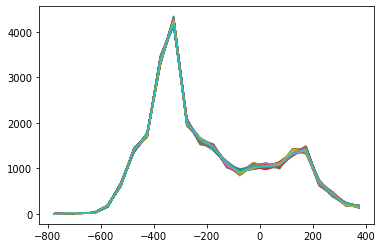

In [178]:
plot_simulations(sim_att)